In [2]:
"""
2D Poisson Equation
    Spatial: Spectral solvers (FFT/FST)
"""
import sys
import numpy as np
import scipy
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
import scipy.sparse
import numpy.linalg
from tqdm.notebook import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [3]:
def rms(a):
    return np.sqrt(np.mean(a**2))

In [4]:
def ExactSolution(x,y):
    return np.sin(2*np.pi*x)*np.sin(2*np.pi*y) + 1/16**2 * np.sin(32*np.pi*x)*np.sin(32*np.pi*y)

def SourceTerm(x,y):
    return -8*np.pi**2*np.sin(2*np.pi*x)*np.sin(2*np.pi*y) -8*np.pi**2*np.sin(32*np.pi*x)*np.sin(32*np.pi*y)

In [5]:
def PoissonFFTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[:-1,:-1]
    m = np.roll(mA[:-1,:-1] - Nx/2, (int(Nx/2),int(Ny/2)), axis=(0,1)) # the way of defing wavenumber array is very important
    n = np.roll(nA[:-1,:-1] - Ny/2, (int(Nx/2),int(Ny/2)), axis=(0,1)) # should be 0,1,2,3...,N/2, -N/2+1,-N/2+2,...
    fTilda = scipy.fft.fft2(f)
    u = fA*np.nan
    uTilda = fTilda/(2/dX**2*np.cos(2*np.pi*m/Nx) + 2/dY**2*np.cos(2*np.pi*n/Ny)-2/dX**2-2/dY**2+eps)
    u[:-1,:-1] = np.real(scipy.fft.ifft2(uTilda))
    u[-1,:] = u[0,:]
    u[:,-1] = u[:,0]
    return u


In [6]:
def PoissonFFTSpectral(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[:-1,:-1]
    m = np.roll(mA[:-1,:-1] - Nx/2, (int(Nx/2),int(Ny/2)), axis=(0,1))
    n = np.roll(nA[:-1,:-1] - Ny/2, (int(Nx/2),int(Ny/2)), axis=(0,1))
    fTilda = scipy.fft.fft2(f)
    u = fA*np.nan
    uTilda = -fTilda/((2*np.pi*m/(Nx*dX))**2+(2*np.pi*n/(Ny*dY))**2+eps)
    u[:-1,:-1] = np.real(scipy.fft.ifft2(uTilda))
    u[-1,:] = u[0,:]
    u[:,-1] = u[:,0]
    return u


In [7]:
def PoissonFSTCentralDiff(fA, dX, dY, mA, nA, Nx, Ny):
    eps = 1e-10
    f = fA[1:-1,1:-1]
    m = mA[1:-1,1:-1] # important to plus 1
    n = nA[1:-1,1:-1]
    fTilda = scipy.fft.dstn(f)
    u = fA*0
    uTilda = fTilda/(2/dX**2*np.cos(np.pi*m/Nx) + 2/dY**2*np.cos(np.pi*n/Ny)-2/dX**2-2/dY**2+eps)
    u[1:-1,1:-1] = np.real(scipy.fft.idstn(uTilda))
    return u


In [8]:
xMin, xMax = 0.0, 1.0
yMin, yMax = 0.0, 1.0

numXCen = 1024
numYCen = 1024
numXGrid = numXCen+1
numYGrid = numYCen+1

xMat, yMat = np.meshgrid(np.linspace(xMin, xMax, numXGrid), np.linspace(yMin, yMax, numYGrid), indexing="ij")
mMat, nMat = np.meshgrid(np.arange(numXGrid), np.arange(numYGrid), indexing="ij")

uExact = ExactSolution(xMat,yMat)

xArray = xMat.flatten()
yArray = yMat.flatten()
mArray = mMat.flatten()
nArray = nMat.flatten()

deltaX = xMat[1,0] - xMat[0,0]
deltaY = yMat[0,1] - yMat[0,0]

rhsF = SourceTerm(xMat, yMat)
u = PoissonFSTCentralDiff(rhsF, deltaX, deltaY, mMat, nMat, numXCen, numYCen)
# u = PoissonFFTCentralDiff(rhsF, deltaX, deltaY, mMat, nMat, numXCen, numYCen)
# u[numXGrid,:] = u[0,:]
# u[:,numYGrid] = u[:,0]

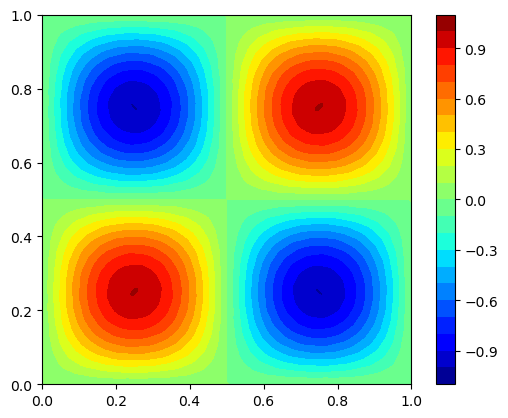

In [9]:
fig,ax = plt.subplots()
cs = ax.contourf(xMat, yMat, u, 20, cmap=cm.get_cmap('jet'))
ax.set_xlim((xMin,xMax))
ax.set_ylim((yMin,yMax))
ax.set_aspect("equal")
cbar = fig.colorbar(cs)

In [10]:
print(rms(u-uExact))

0.0009941995926340786
